## <center><strong>Notebook describtion & Our <span style= 'color: #51fcc6'>Questions</span>

In this notebook we are going to create the charts that we are going to use in the final pdf report and the tools we are going<br>
to use are matplotlib and seaborn.

#### **Questions we are going to awnser:**
1. How many jobs are available per country and per profession on Likedin.

2. What's the ratio between people who earned money on UpWork Vs Guru.

3. Average salary per profession and per country on LinkedIn.

4. What's Top 5 people in earnings amount most frequent words in thier describtions.<sub> *(In upwork</sub>

5. What's Worst 5 people in earnings amount most frequent words in thier describtions.<sub> *(In upwork)</sub>

6. What are the most appending skills in the job titels per profession.<sub> *(In upwork & LinkedIn)</sub>

7. What are the Top 10 skills in earnings. <sub> *(In upwork & LinkedIn)</sub>

8. Correlation between Earnings amount, Years of Exp, Hour rate & Feedback in Upwork.

9. Does the Consultations offers affect the Earnings amount strongly.

10. Top 3 countries in total freelancers earnings Vs Top 3 countries in freelancers count <sub> *(In upwork & guru)</sub>

11. Jobs count per Jobs location per profession.

12. Where are the most job loactions in general per profession.

13. What's the average salary per proffision & per country.

14. What's the most common Employment type per data jobs in general.

15. Jobs count vs listing dates per proffision to see thier growth trends.

16. most common Earning abount, hour rate, exp years per proffision in Upwork.

#### **Important note:**
I am going to use  **`pandasql`** to read the data from the dfs so I can create plots more easly using SQL<br>
queries inside python.

## <center><strong>Importing the <span style= 'color: #48e0dc'>Packeges 

In [23]:
import os
import warnings
import matplotlib
import pandasql           as ps
import pandas             as pd
import numpy              as np
import seaborn            as sns
import matplotlib.pyplot  as plt

from google.cloud         import bigquery
from wordcloud            import WordCloud
from collections          import Counter

In [24]:
%matplotlib inline
plt.rcParams['font.family'] = 'Candara'

warnings.filterwarnings('ignore')

credentials_path :str = '../credentials.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credentials_path

FONT             :int  = 20
COLORS           :list = ['#51fcc6', '#48e0dc', '#5cd3f7', '#4895e0', '#517afc']
NUMERICS         :list = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64',
                          'uint16', 'uint32', 'uint64']

## <center><strong>Loading the data & basic data <span style= 'color: #5cd3f7'>Cleaning

In [25]:
project_id :str = 'data-jobs-analysis-db'
dataset_id :str = 'data_jobs_analysis_db'

query_pandas  = lambda q: ps.sqldf(q, globals())
client        = bigquery.Client(project= project_id)

linkedin_jobs    = client.query(f'SELECT * FROM {dataset_id}.linkedin_jobs_new;').to_dataframe()
upwork_profiles  = client.query(f'SELECT * FROM {dataset_id}.upwork_profiles_new;').to_dataframe()
guru_profiles    = client.query(f'SELECT * FROM {dataset_id}.guru_profiles_new;').to_dataframe()

In [26]:
cm = sns.light_palette(COLORS[0], as_cmap=True)

linkedin_jobs.drop(['describtion', 'jobs_links', 'jobs_titles', 'skills']
                   , axis= 1).sample(5).style.background_gradient(cmap= cm)

,jobs_locations,listing_dates,companies_names,location_type,employment_type,industry,reqierd_credential,country,job_title,total_jobs,salary,programming_lang,exp_years
675,"Emeryville, CA",2023-03-25,Liminal,Hybrid,FULL_TIME,"Technology, Information and Internet",bachelor degree,European Union,Data engineer,39000,175000.000000,['c++' 'rust' 'scala' 'java' 'python' 'c#'],4.000000
68,"Menlo Park, CA",2023-07-07,Meta,Remote,FULL_TIME,"Technology, Information and Internet",bachelor degree,European Union,ML developer,989,nan,['c++'],4.666667
3125,"Foster City, CA",2023-07-06,Trillium Staffing Solutions,Remote,FULL_TIME,Staffing and Recruiting,bachelor degree,United States,Data engineer,76000,90.000000,[],3.333333
71,"Burlingame, CA",2023-07-13,Meta,Remote,FULL_TIME,"Technology, Information and Internet",bachelor degree,European Union,ML developer,989,nan,['c++' 'python'],nan
2868,"Hayward, CA",2023-02-01,Recruiting from Scratch,Remote,FULL_TIME,Staffing and Recruiting,bachelor degree,European Union,ML developer,989,205000.000000,['sql' 'c++' 'scala'],5.000000


In [27]:
cm = sns.light_palette(COLORS[2], as_cmap=True)

upwork_profiles.drop(['describtion', 'skills']
                   , axis= 1).sample(5).style.background_gradient(cmap= cm)

,Unnamed__0,feedback,name,job_title,country,consultations_offers,data_job_title,new_columns,earnings_amount_new,hour_rate_new,exp_years
11,,nan,Tahir A.,Data Science Speaker at Kaggle Days | IBM Data Engineer and Analyst,Pakistan,Offers consultations,Data scientist,"{'earnings_amount_new': None, 'hour_rate_new': 20.0}",,20.000000,nan
866,,100.000000,Fahad K.,Innovative Big Data Engineer and Scientist with Expertise in ETL,Pakistan,Doesn't offer consultations,Data Engineering,"{'earnings_amount_new': 300000, 'hour_rate_new': 40.0}",300000,40.000000,nan
157,,96.000000,Ukasha J.,Lead Generation & Data Entry Expert | Finding Leads,Pakistan,Doesn't offer consultations,Data entry,"{'earnings_amount_new': None, 'hour_rate_new': 3.99}",,3.990000,nan
802,,84.000000,Oliver W.,"Advanced data analysis, machine learning, and data visualization",South Africa,Doesn't offer consultations,Machine Learning,"{'earnings_amount_new': 3000, 'hour_rate_new': 30.0}",3000,30.000000,10.000000
594,,98.000000,Adnan N.,"Skip Tracing |TLOxp| Data Entry|Lead Generation |Emails,Phone provider",Pakistan,Doesn't offer consultations,Data entry,"{'earnings_amount_new': 70000, 'hour_rate_new': 5.0}",70000,5.000000,nan


In [28]:
cm = sns.light_palette(COLORS[4], as_cmap=True)

guru_profiles.drop(['describtion', 'skills']
                   , axis= 1).sample(5).style.background_gradient(cmap= cm)

,Unnamed__0,name,job_title,addresse,minimum_pay,data_job_title,new_columns,earnings_amount_new,hour_rate_new,feedback_new
1075,,Nimisha Jain,Lead Generation,"Pune, Maharashtra, India",25.000000,Data entry,"{'earnings_amount_new': 1381, 'feedback_new': 203.0, 'hour_rate_new': 1125.0}",1381,1125.000000,203.000000
553,,Manish Nair 2,"Data Scientist, Business Analytics","Bangalore, Karnataka, India",25.000000,Data scientist,"{'earnings_amount_new': 0, 'feedback_new': 0.0, 'hour_rate_new': 1025.0}",0,1025.000000,0.000000
1513,,Ufuk Hurriyetoglu,Senior Machine Learning Engineer,"Istanbul, Istanbul, Turkey",50.000000,Machine Learning,"{'earnings_amount_new': 0, 'feedback_new': 0.0, 'hour_rate_new': 7050.0}",0,7050.000000,0.000000
1843,,Mohamed Mahmoud Ali Mahmoud,Machine learning/Data engineer,"Giza, Al Jizah, Egypt",35.000000,Data Engineering,"{'earnings_amount_new': 0, 'feedback_new': 0.0, 'hour_rate_new': 1035.0}",0,1035.000000,0.000000
812,,reb maa,Big data engineer,"Puteaux, Ile-de-France, France",25.000000,Data Engineering,"{'earnings_amount_new': 0, 'feedback_new': 0.0, 'hour_rate_new': 3025.0}",0,3025.000000,0.000000


#### **Basic cleaning:**

In [29]:
upwork_profiles.drop(['Unnamed__0', 'new_columns'], axis= 1, inplace= True)
guru_profiles.drop(['Unnamed__0', 'new_columns'], axis= 1, inplace= True)

linkedin_jobs.drop(['jobs_links'], axis= 1, inplace= True)

linkedin_jobs['salary'] = linkedin_jobs['salary'].where((linkedin_jobs.salary < 70) |
                                                        (linkedin_jobs.salary > 10_000) &
                                                        (linkedin_jobs.salary > 5))

per_hour_or_year_map = lambda salary: 'per year' if salary > 10_000 else 'per hour' if salary < 100 else np.nan
linkedin_jobs['per_hour_or_year'] = linkedin_jobs['salary'].apply(per_hour_or_year_map)

## <center><strong><span style= 'color: #5cd3f7'>Visualizing</span> the data (part 1)

In [30]:
def add_bar_labels(x,y, ax, scaler= 0):
    for i in range(len(x)):
        ax.text(i, y[i] + scaler , '{:,}'.format(y[i]), ha = 'center')

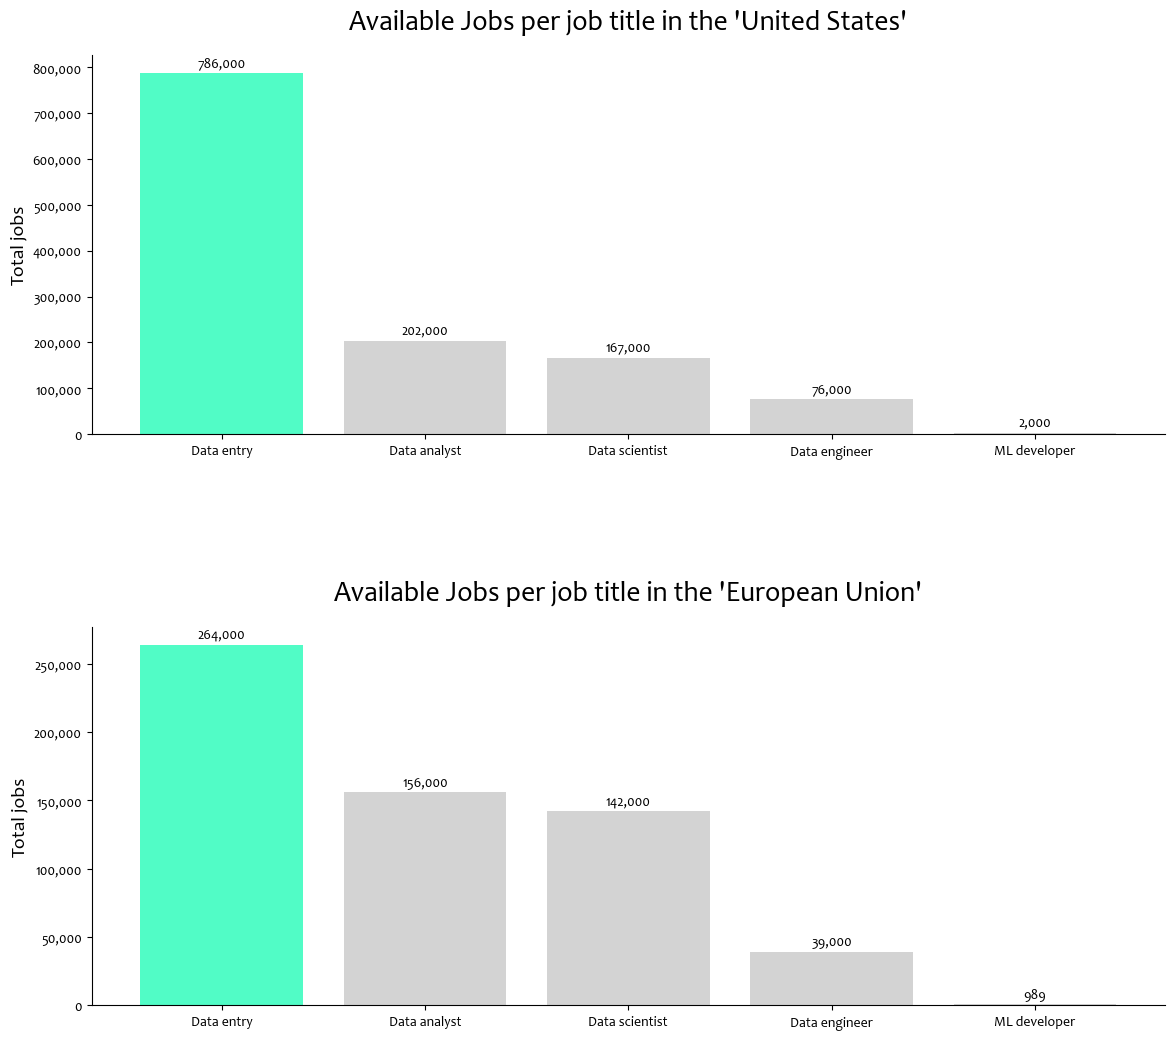

In [31]:
fig, (ax1, ax2) = plt.subplots(nrows= 2)

countries = ['\'United States\'', '\'European Union\'']

colors_temp = [COLORS[0]] * 1
colors_temp += ['lightgrey'] * 5

for ax, country in zip([ax1, ax2], countries):
    
    data = query_pandas(f'''SELECT total_jobs,
                                 job_title,
                                 country
                           FROM linkedin_jobs
                           WHERE country = {country}
                           GROUP BY job_title
                           ORDER BY total_jobs DESC;''')
    
    ax.bar(x=      data['job_title'],
           height= data['total_jobs'],
           color=  colors_temp)
    
    ax.spines[['right', 'top']].set_visible(False)

    ax.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    ax.set_title(f'Available Jobs per job title in the {country}', fontsize= FONT, pad= 19)
    ax.set_ylabel('Total jobs', fontsize= FONT * 3.5/5)
    
    if ax is ax1:
        add_bar_labels(data['job_title'], data['total_jobs'], ax, scaler= 15000)
        
    if ax is ax2:
        add_bar_labels(data['job_title'], data['total_jobs'], ax, scaler= 5000)

        
fig.tight_layout(h_pad=0.5, w_pad=5)
fig.set_size_inches(13, 12)
plt.show()

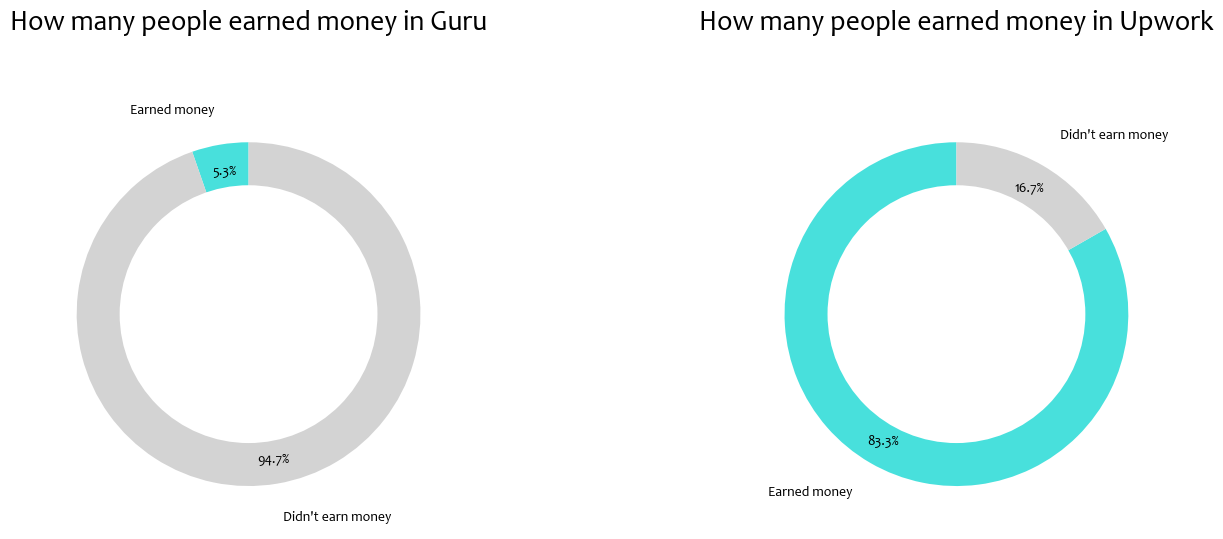

In [32]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

platforms   : list = ['guru', 'upwork']
labels      : list = ['Earned money', 'Didn\'t earn money']
colors_temp : list = [COLORS[1], 'lightgrey']
explode     : list = [0.2, 0.2]

for ax, platform in zip([ax1, ax2], platforms):
    # The first row in the queried table below contains the people who have earned money count
    data = query_pandas(f'''SELECT COUNT(*) AS total_profiles
                           FROM {platform}_profiles
                           WHERE earnings_amount_new > 0
                           
                           UNION ALL
                           
                           SELECT COUNT(*) AS total_profiles
                           FROM {platform}_profiles
                           WHERE earnings_amount_new IS NULL OR 
                                 earnings_amount_new = 0;''')


    # Plot the pie chart on the current axis
    # ax.pie(counts, labels=labels, autopct='%2.1f%%', pctdistance=0.85, labeldistance=1.2, colors= colors_temp)
    
    ax.pie(data['total_profiles'], labels=labels, autopct='%2.1f%%',
           pctdistance=0.85, labeldistance=1.2, colors=colors_temp,
           startangle=90)
    
    ax.set_title(f'How many people earned money in {platform.title()}', fontsize= FONT, pad= 50)
                 
    centre_circle = plt.Circle((0, 0), 0.75, fc='white')
    ax.add_artist(centre_circle)

fig.tight_layout(w_pad=7)
fig.set_size_inches(13, 10)
plt.show()

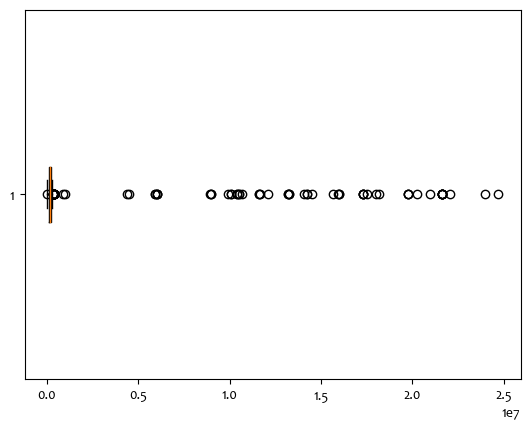

In [33]:
# fig, ax = plt.subplots()

# green_diamond = dict(markerfacecolor= COLORS[1], marker='s')


ax.set_title('Salaries box plot')
plt.boxplot(linkedin_jobs[linkedin_jobs['per_hour_or_year'] == 'per year']["salary"], vert=False)


# plt.savefig("../plots/subs_and_views_box_plot.svg")
# fig.set_size_inches(10, 8)
plt.show()

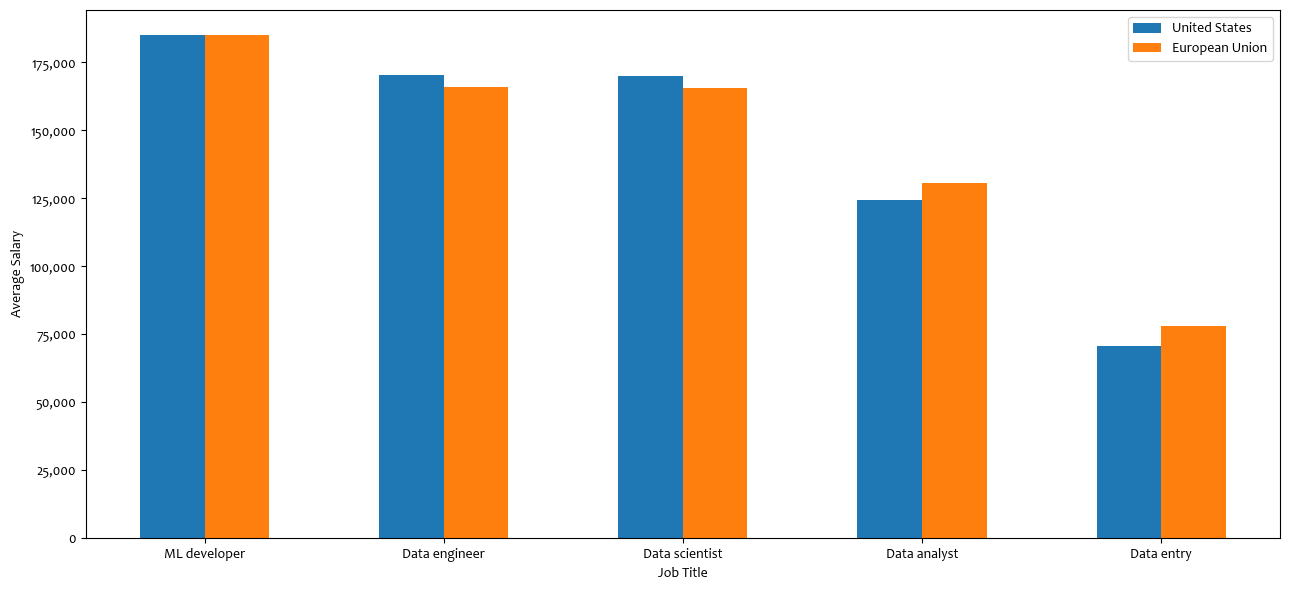

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111)

width = 0.27

data = query_pandas(f'''SELECT AVG(x) AS median_salary,
                               country,
                               job_title

                        FROM (SELECT salary AS x,
                                     country,
                                     job_title,
                                     ROW_NUMBER() OVER (PARTITION BY country, job_title ORDER BY salary) AS row_num,
                                     COUNT(*) OVER (PARTITION BY country, job_title) AS total_rows
                              FROM linkedin_jobs
                              WHERE per_hour_or_year = 'per year') subquery
                        WHERE row_num IN ((total_rows + 1) / 2, (total_rows + 2) / 2)
                        GROUP BY country, job_title
                        ORDER BY median_salary DESC;''')


us_data      = data[data['country'] == 'United States']
eu_data      = data[data['country'] == 'European Union']

positions_us = range(len(us_data))
positions_eu = [pos + width for pos in positions_us]


ax.bar(positions_us, us_data['median_salary'], width,
       align='center', label='United States')

ax.bar(positions_eu, eu_data['median_salary'], width,
       align='center', label='European Union')



ax.set_xticks([pos + width/2 for pos in positions_us])
ax.set_xticklabels(us_data['job_title'], ha='center')
ax.set_xlabel('Job Title')
ax.set_ylabel('Average Salary')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))


ax.legend()
fig.set_size_inches(13, 6)
fig.tight_layout()
plt.show()

In [ ]:
data[data['country'] == 'European Union']['avg_salary']

In [ ]:
linkedin_jobs.sample(30)